In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [4]:

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [5]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [6]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [7]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [8]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [9]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

<ipython-input-9-9dd469a3f9cb>:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [10]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

<ipython-input-10-f391b7cb3b7b>:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [11]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [12]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [13]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [14]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [15]:
n_steps = 4
n_features = trainX.shape[2]
n_length = 32

trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))
print(trainX.shape,testX.shape)

(4067, 4, 32, 9) (1560, 4, 32, 9)


In [16]:
n_timesteps, n_features, n_outputs = n_steps * n_length, trainX.shape[3], testy_one_hot.shape[1]

# CNN1 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 30, 64)      1792      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               4

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 21s 44ms/step - loss: 0.3916 - accuracy: 0.8311 - val_loss: 0.2076 - val_accuracy: 0.8943
Epoch 2/10
32/32 [==============================] - 0s 14ms/step - loss: 0.2186 - accuracy: 0.9078 - val_loss: 0.2042 - val_accuracy: 0.9050
Epoch 3/10
32/32 [==============================] - 0s 14ms/step - loss: 0.2018 - accuracy: 0.9122 - val_loss: 0.1970 - val_accuracy: 0.9263
Epoch 4/10
32/32 [==============================] - 0s 14ms/step - loss: 0.2057 - accuracy: 0.9107 - val_loss: 0.2141 - val_accuracy: 0.9132
Epoch 5/10
32/32 [==============================] - 0s 11ms/step - loss: 0.1996 - accuracy: 0.9137 - val_loss: 0.2018 - val_accuracy: 0.9025
Epoch 6/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1975 - accuracy: 0.9120 - val_loss: 0.1901 - val_accuracy: 0.9173
Epoch 7/10
32/32 [==============================] - 0s 10ms/step - loss: 0.1852 - accuracy: 0.9174 - val_loss: 0.1829 - val_accuracy: 0.9238
Epoch 8/10
3

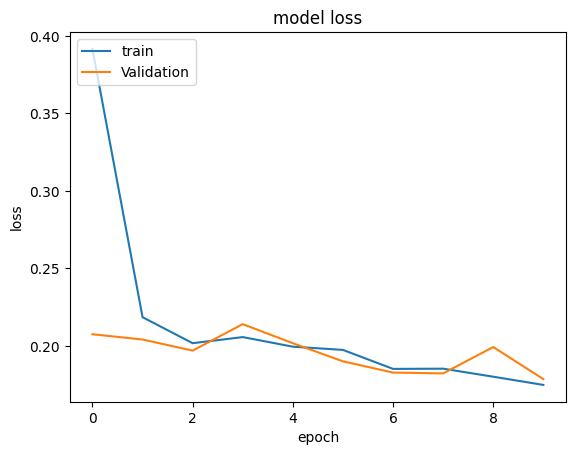

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

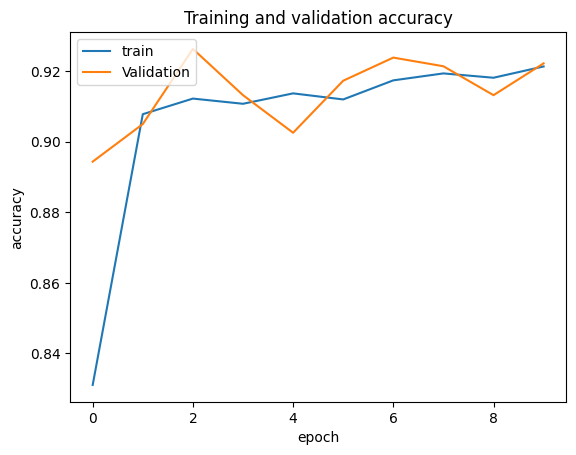

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 4ms/step
[[408  83   0]
 [105 427   0]
 [  0  27 510]]
0.8621794871794872
0.8635989934496435
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       491
           1       0.80      0.80      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.87      0.86      0.86      1560



<Axes: >

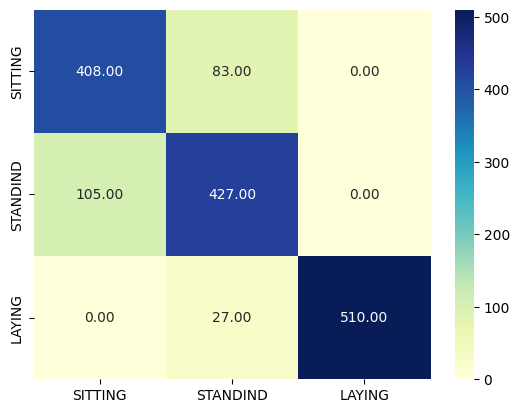

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer 3

# CNN 1 - LSTM2



In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 30, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 15, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 960)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, None, 100)        

In [ ]:

# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 7s 35ms/step - loss: 0.4587 - accuracy: 0.8016 - val_loss: 0.2361 - val_accuracy: 0.8894
Epoch 2/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2347 - accuracy: 0.9019 - val_loss: 0.2091 - val_accuracy: 0.9206
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2102 - accuracy: 0.9075 - val_loss: 0.2042 - val_accuracy: 0.9247
Epoch 4/10
32/32 [==============================] - 0s 9ms/step - loss: 0.2035 - accuracy: 0.9122 - val_loss: 0.1929 - val_accuracy: 0.9271
Epoch 5/10
32/32 [==============================] - 0s 9ms/step - loss: 0.1943 - accuracy: 0.9162 - val_loss: 0.1876 - val_accuracy: 0.9263
Epoch 6/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1821 - accuracy: 0.9181 - val_loss: 0.1839 - val_accuracy: 0.9247
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1874 - accuracy: 0.9221 - val_loss: 0.1854 - val_accuracy: 0.9189
Epoch 8/10
32/32 

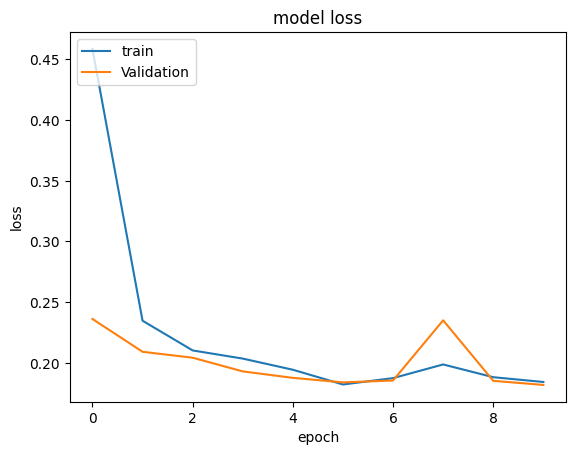

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

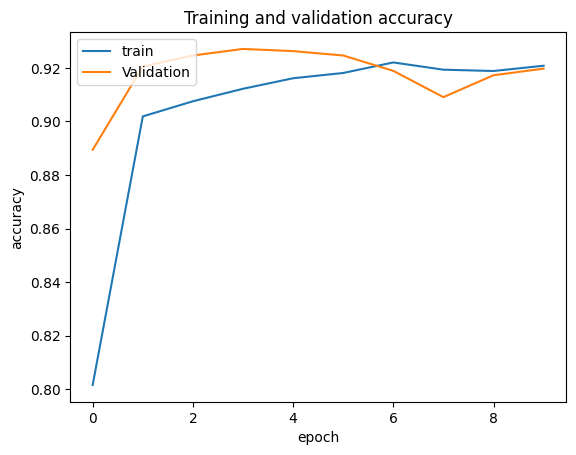

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 2s 4ms/step
[[396  95   0]
 [ 75 457   0]
 [  0  27 510]]
0.8737179487179487
0.8750331265344238
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       491
           1       0.79      0.86      0.82       532
           2       1.00      0.95      0.97       537

    accuracy                           0.87      1560
   macro avg       0.88      0.87      0.87      1560
weighted avg       0.88      0.87      0.88      1560



<Axes: >

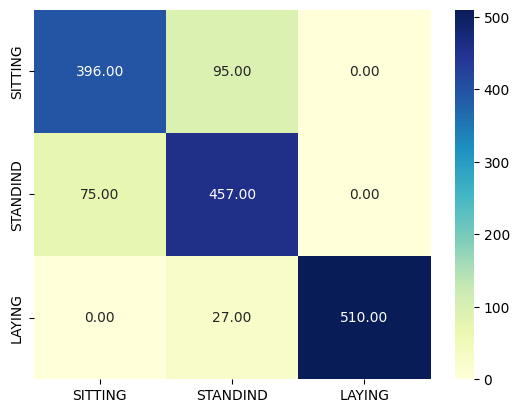

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 28, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 896)        

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 5s 42ms/step - loss: 0.3874 - accuracy: 0.8289 - val_loss: 0.2153 - val_accuracy: 0.9238
Epoch 2/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2293 - accuracy: 0.8999 - val_loss: 0.2068 - val_accuracy: 0.9124
Epoch 3/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2038 - accuracy: 0.9132 - val_loss: 0.2016 - val_accuracy: 0.9058
Epoch 4/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1909 - accuracy: 0.9164 - val_loss: 0.1929 - val_accuracy: 0.9181
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1812 - accuracy: 0.9181 - val_loss: 0.1931 - val_accuracy: 0.9197
Epoch 6/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1875 - accuracy: 0.9130 - val_loss: 0.1924 - val_accuracy: 0.9148
Epoch 7/10
32/32 [==============================] - 0s 8ms/step - loss: 0.1759 - accuracy: 0.9179 - val_loss: 0.1749 - val_accuracy: 0.9140
Epoch 8/10
32/32 

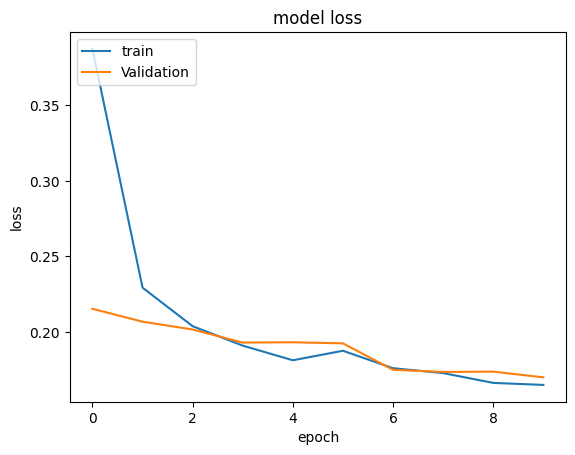

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

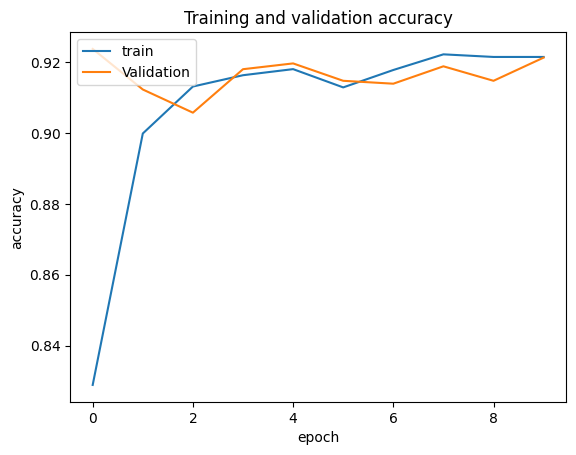

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[427  64   0]
 [100 432   0]
 [  0  27 510]]
0.8775641025641026
0.8786775474726931
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       491
           1       0.83      0.81      0.82       532
           2       1.00      0.95      0.97       537

    accuracy                           0.88      1560
   macro avg       0.88      0.88      0.88      1560
weighted avg       0.88      0.88      0.88      1560



<Axes: >

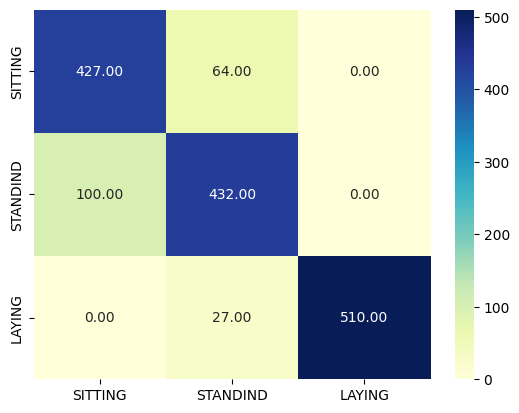

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer4

# CNN1 - LSTM3

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 30, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 15, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 960)         0         
 istributed)                                                     
                                                                 
 lstm_4 (LSTM)               (None, None, 100)        

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 7s 45ms/step - loss: 0.5371 - accuracy: 0.7807 - val_loss: 0.2180 - val_accuracy: 0.8886
Epoch 2/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2298 - accuracy: 0.9029 - val_loss: 0.2048 - val_accuracy: 0.9238
Epoch 3/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2100 - accuracy: 0.9152 - val_loss: 0.1984 - val_accuracy: 0.9247
Epoch 4/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2004 - accuracy: 0.9139 - val_loss: 0.1858 - val_accuracy: 0.9247
Epoch 5/10
32/32 [==============================] - 0s 15ms/step - loss: 0.2008 - accuracy: 0.9147 - val_loss: 0.1836 - val_accuracy: 0.9222
Epoch 6/10
32/32 [==============================] - 1s 16ms/step - loss: 0.1952 - accuracy: 0.9176 - val_loss: 0.1825 - val_accuracy: 0.9247
Epoch 7/10
32/32 [==============================] - 0s 14ms/step - loss: 0.1874 - accuracy: 0.9194 - val_loss: 0.1853 - val_accuracy: 0.9165
Epoch 8/10
32

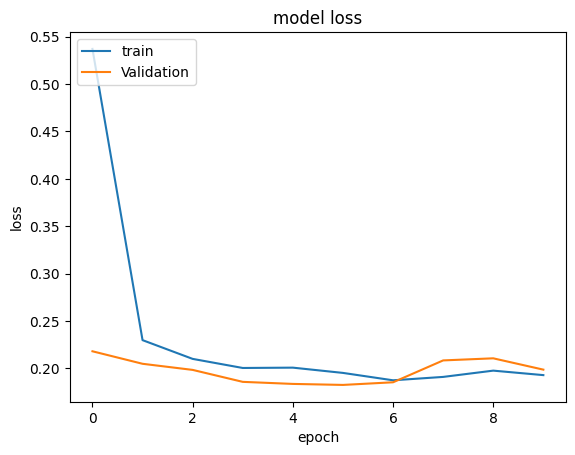

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

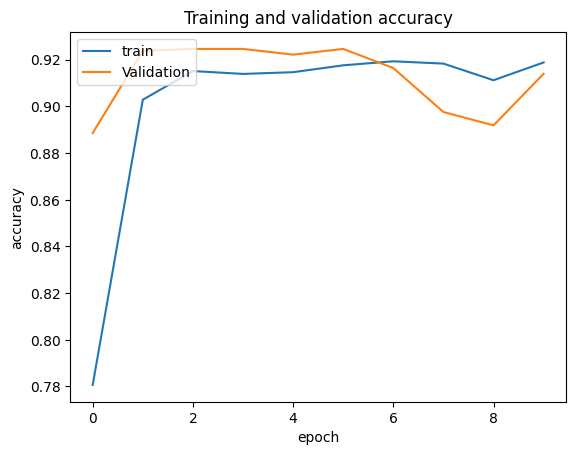

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 2s 3ms/step
[[423  68   0]
 [117 415   0]
 [  0  27 510]]
0.8641025641025641
0.8652628691603867
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       491
           1       0.81      0.78      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.86      1560
   macro avg       0.87      0.86      0.86      1560
weighted avg       0.87      0.86      0.87      1560



<Axes: >

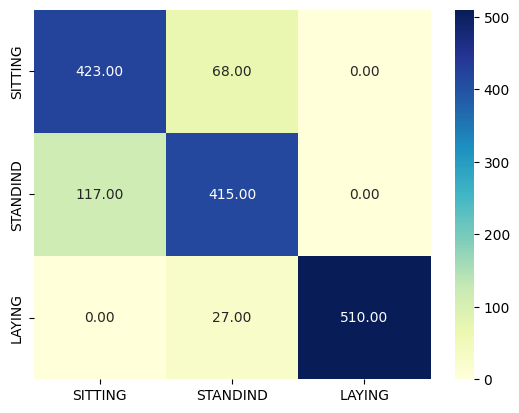

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, None, 896)        

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 6s 50ms/step - loss: 0.4412 - accuracy: 0.8303 - val_loss: 0.2296 - val_accuracy: 0.8837
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2234 - accuracy: 0.9093 - val_loss: 0.1974 - val_accuracy: 0.9050
Epoch 3/10
32/32 [==============================] - 0s 15ms/step - loss: 0.2181 - accuracy: 0.9073 - val_loss: 0.2182 - val_accuracy: 0.8862
Epoch 4/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2039 - accuracy: 0.9073 - val_loss: 0.1882 - val_accuracy: 0.9214
Epoch 5/10
32/32 [==============================] - 0s 14ms/step - loss: 0.1930 - accuracy: 0.9132 - val_loss: 0.1843 - val_accuracy: 0.9156
Epoch 6/10
32/32 [==============================] - 0s 14ms/step - loss: 0.1831 - accuracy: 0.9191 - val_loss: 0.1783 - val_accuracy: 0.9173
Epoch 7/10
32/32 [==============================] - 0s 14ms/step - loss: 0.1754 - accuracy: 0.9206 - val_loss: 0.1680 - val_accuracy: 0.9206
Epoch 8/10
32

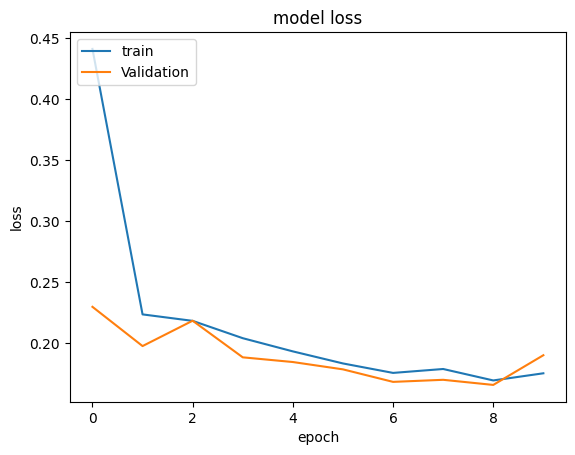

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

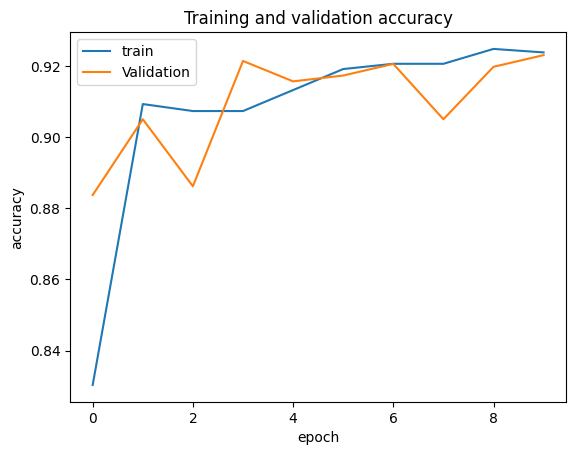

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[382 109   0]
 [ 51 481   0]
 [  0  27 510]]
0.8801282051282051
0.8811199369805833
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       491
           1       0.78      0.90      0.84       532
           2       1.00      0.95      0.97       537

    accuracy                           0.88      1560
   macro avg       0.89      0.88      0.88      1560
weighted avg       0.89      0.88      0.88      1560



<Axes: >

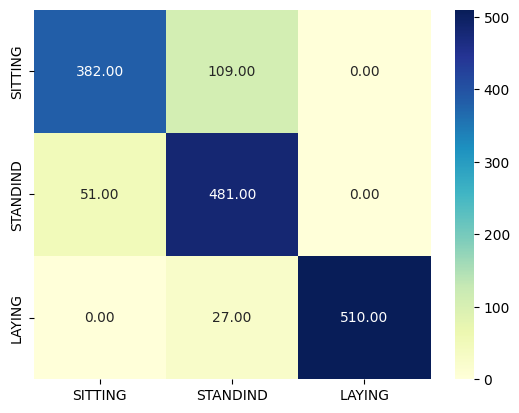

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_23 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_24 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, None, 12, 64)     

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 5s 43ms/step - loss: 0.4329 - accuracy: 0.8237 - val_loss: 0.2431 - val_accuracy: 0.8862
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2231 - accuracy: 0.9068 - val_loss: 0.2650 - val_accuracy: 0.8829
Epoch 3/10
32/32 [==============================] - 0s 12ms/step - loss: 0.2057 - accuracy: 0.9130 - val_loss: 0.2371 - val_accuracy: 0.9050
Epoch 4/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1963 - accuracy: 0.9162 - val_loss: 0.2192 - val_accuracy: 0.9197
Epoch 5/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1887 - accuracy: 0.9194 - val_loss: 0.2253 - val_accuracy: 0.9058
Epoch 6/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1942 - accuracy: 0.9166 - val_loss: 0.2555 - val_accuracy: 0.9132
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1794 - accuracy: 0.9198 - val_loss: 0.2101 - val_accuracy: 0.9238
Epoch 8/10
32

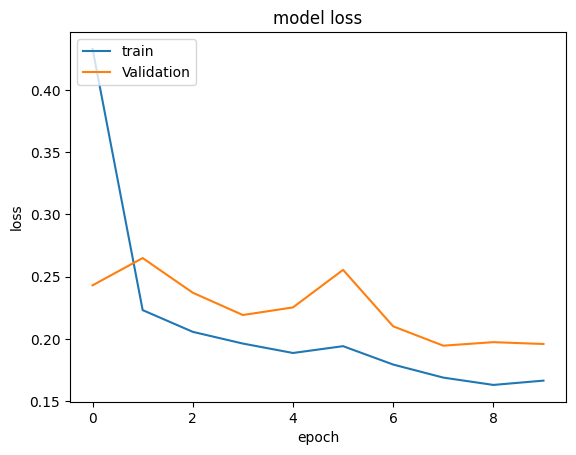

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

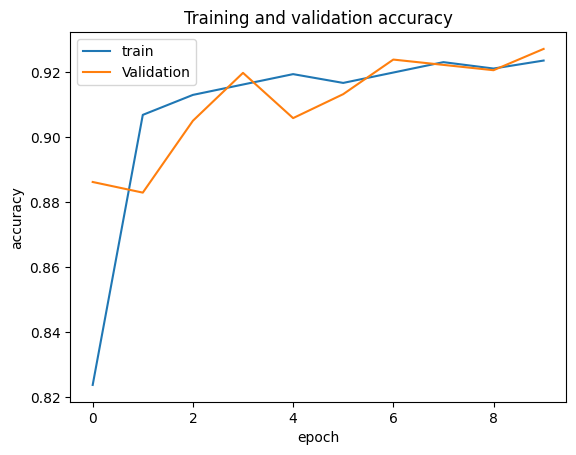

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 3ms/step
[[398  91   2]
 [ 94 438   0]
 [  0   0 537]]
0.8801282051282051
0.8800227115469721
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       491
           1       0.83      0.82      0.83       532
           2       1.00      1.00      1.00       537

    accuracy                           0.88      1560
   macro avg       0.88      0.88      0.88      1560
weighted avg       0.88      0.88      0.88      1560



<Axes: >

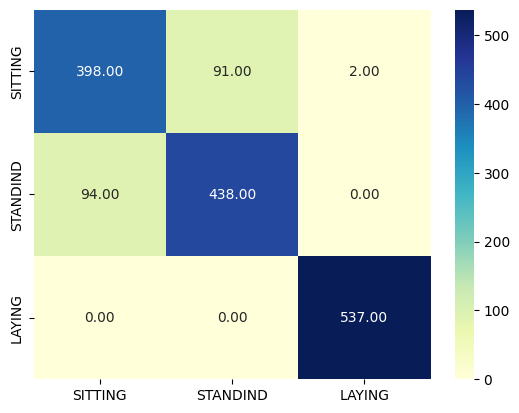

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# Layer5

# CNN

# C4 L1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeD  (None, None, 30, 64)      1792      
 istributed)                                                     
                                                                 
 time_distributed_31 (TimeD  (None, None, 28, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_32 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_33 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_34 (TimeD  (None, None, 12, 64)     

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 5s 33ms/step - loss: 0.4860 - accuracy: 0.7797 - val_loss: 0.2373 - val_accuracy: 0.8952
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2278 - accuracy: 0.9083 - val_loss: 0.2589 - val_accuracy: 0.9214
Epoch 3/10
32/32 [==============================] - 0s 13ms/step - loss: 0.2073 - accuracy: 0.9134 - val_loss: 0.2476 - val_accuracy: 0.9165
Epoch 4/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1965 - accuracy: 0.9181 - val_loss: 0.2346 - val_accuracy: 0.9222
Epoch 5/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1968 - accuracy: 0.9120 - val_loss: 0.2541 - val_accuracy: 0.8853
Epoch 6/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1916 - accuracy: 0.9194 - val_loss: 0.2029 - val_accuracy: 0.9230
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1880 - accuracy: 0.9147 - val_loss: 0.2158 - val_accuracy: 0.9173
Epoch 8/10
32

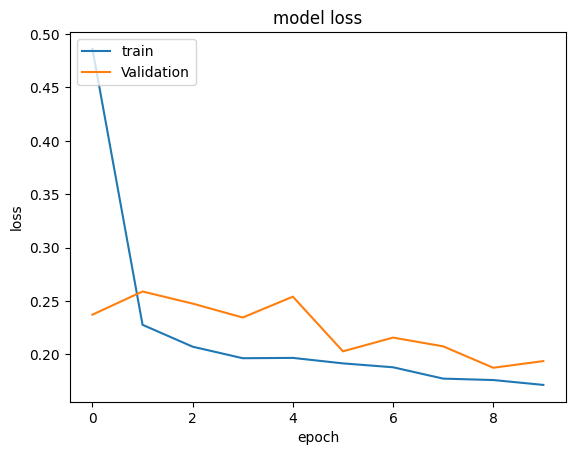

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

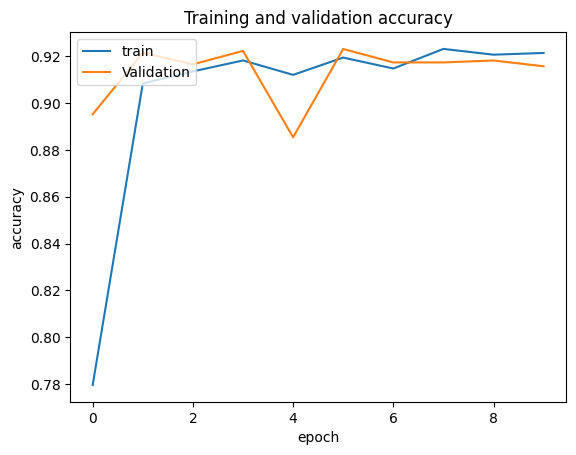

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 1s 4ms/step
[[417  74   0]
 [ 80 452   0]
 [  0  27 510]]
0.8839743589743589
0.8851737735278471
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       491
           1       0.82      0.85      0.83       532
           2       1.00      0.95      0.97       537

    accuracy                           0.88      1560
   macro avg       0.89      0.88      0.88      1560
weighted avg       0.89      0.88      0.89      1560



<Axes: >

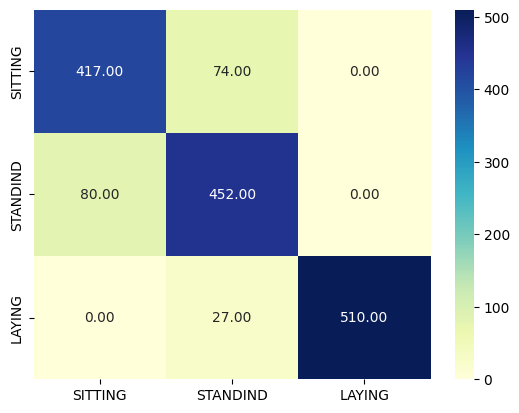

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3 - LSTM2

In [17]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))


model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 30, 64)      1792      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 28, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 28, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 14, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, None, 12, 64)      1

In [18]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 27s 50ms/step - loss: 0.5074 - accuracy: 0.8040 - val_loss: 0.2933 - val_accuracy: 0.8657
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2397 - accuracy: 0.8997 - val_loss: 0.2359 - val_accuracy: 0.8870
Epoch 3/10
32/32 [==============================] - 0s 11ms/step - loss: 0.2139 - accuracy: 0.9127 - val_loss: 0.2372 - val_accuracy: 0.9189
Epoch 4/10
32/32 [==============================] - 0s 10ms/step - loss: 0.2005 - accuracy: 0.9162 - val_loss: 0.1983 - val_accuracy: 0.9206
Epoch 5/10
32/32 [==============================] - 0s 11ms/step - loss: 0.1992 - accuracy: 0.9216 - val_loss: 0.2137 - val_accuracy: 0.9230
Epoch 6/10
32/32 [==============================] - 0s 11ms/step - loss: 0.1918 - accuracy: 0.9194 - val_loss: 0.1887 - val_accuracy: 0.9222
Epoch 7/10
32/32 [==============================] - 0s 12ms/step - loss: 0.1861 - accuracy: 0.9243 - val_loss: 0.1907 - val_accuracy: 0.9238
Epoch 8/10
3

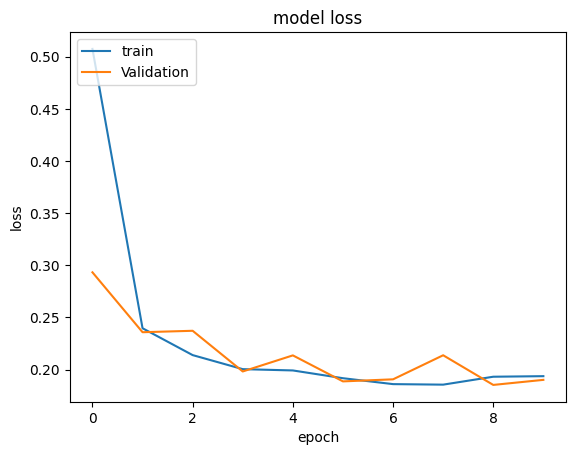

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

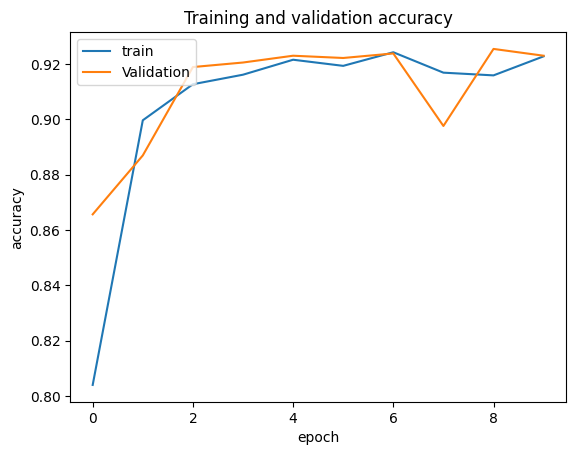

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 6ms/step
[[407  83   1]
 [115 417   0]
 [  0  19 518]]
0.8602564102564103
0.8612387220255302
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       491
           1       0.80      0.78      0.79       532
           2       1.00      0.96      0.98       537

    accuracy                           0.86      1560
   macro avg       0.86      0.86      0.86      1560
weighted avg       0.86      0.86      0.86      1560



<Axes: >

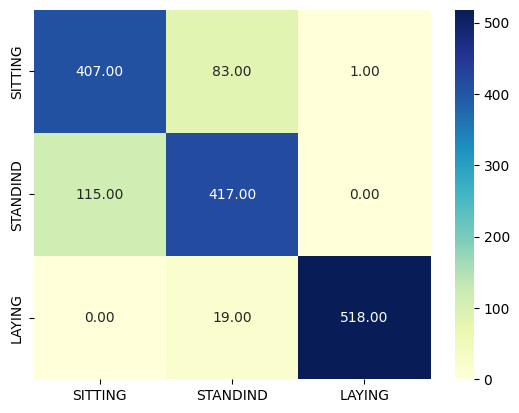

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2-LSTM3

In [23]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))


model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))




model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 30, 64)      1792      
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 28, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 28, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 14, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 896)        

In [24]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 12s 77ms/step - loss: 0.6219 - accuracy: 0.6654 - val_loss: 0.4633 - val_accuracy: 0.7789
Epoch 2/10
32/32 [==============================] - 1s 25ms/step - loss: 0.3393 - accuracy: 0.8458 - val_loss: 0.2401 - val_accuracy: 0.8976
Epoch 3/10
32/32 [==============================] - 1s 23ms/step - loss: 0.2613 - accuracy: 0.8957 - val_loss: 0.2238 - val_accuracy: 0.8952
Epoch 4/10
32/32 [==============================] - 1s 23ms/step - loss: 0.2172 - accuracy: 0.9137 - val_loss: 0.1975 - val_accuracy: 0.9230
Epoch 5/10
32/32 [==============================] - 1s 23ms/step - loss: 0.2000 - accuracy: 0.9139 - val_loss: 0.1852 - val_accuracy: 0.9197
Epoch 6/10
32/32 [==============================] - 1s 23ms/step - loss: 0.1924 - accuracy: 0.9139 - val_loss: 0.1791 - val_accuracy: 0.9238
Epoch 7/10
32/32 [==============================] - 1s 21ms/step - loss: 0.1858 - accuracy: 0.9184 - val_loss: 0.1890 - val_accuracy: 0.9025
Epoch 8/10
3

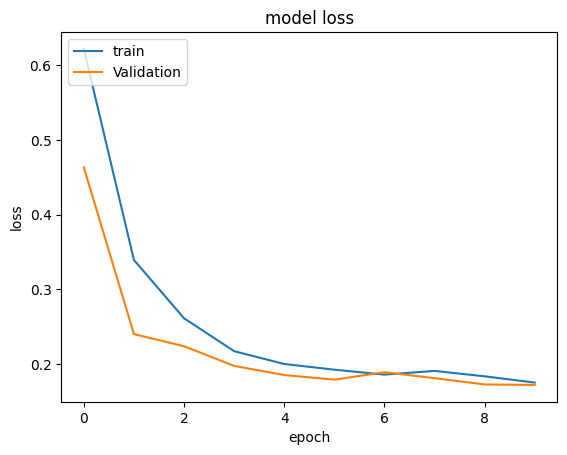

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

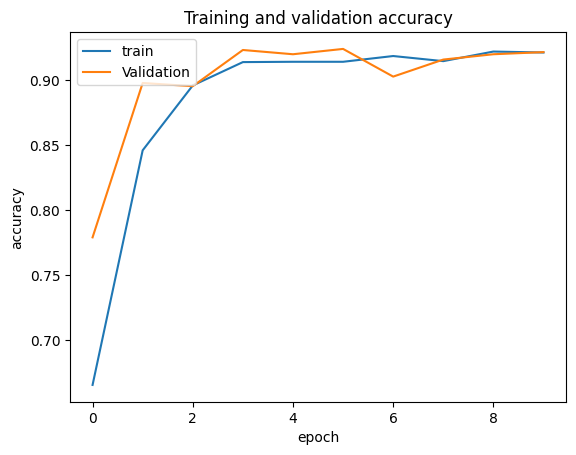

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 2s 4ms/step
[[432  59   0]
 [119 413   0]
 [  0  27 510]]
0.8685897435897436
0.8695486071773288
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       491
           1       0.83      0.78      0.80       532
           2       1.00      0.95      0.97       537

    accuracy                           0.87      1560
   macro avg       0.87      0.87      0.87      1560
weighted avg       0.87      0.87      0.87      1560



<Axes: >

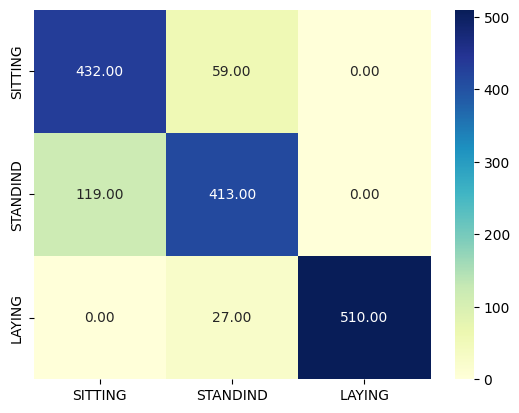

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

#CNN1 - LSTM4

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [28]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
32/32 [==============================] - 1s 19ms/step - loss: 0.1722 - accuracy: 0.9238 - val_loss: 0.1602 - val_accuracy: 0.9230
Epoch 2/10
32/32 [==============================] - 0s 13ms/step - loss: 0.1676 - accuracy: 0.9245 - val_loss: 0.1614 - val_accuracy: 0.9287
Epoch 3/10
32/32 [==============================] - 1s 19ms/step - loss: 0.1769 - accuracy: 0.9196 - val_loss: 0.1888 - val_accuracy: 0.9263
Epoch 4/10
32/32 [==============================] - 1s 21ms/step - loss: 0.1794 - accuracy: 0.9228 - val_loss: 0.1658 - val_accuracy: 0.9197
Epoch 5/10
32/32 [==============================] - 1s 25ms/step - loss: 0.2306 - accuracy: 0.9134 - val_loss: 0.1868 - val_accuracy: 0.9132
Epoch 6/10
32/32 [==============================] - 1s 25ms/step - loss: 0.1788 - accuracy: 0.9176 - val_loss: 0.2031 - val_accuracy: 0.9156
Epoch 7/10
32/32 [==============================] - 1s 26ms/step - loss: 0.1779 - accuracy: 0.9191 - val_loss: 0.1586 - val_accuracy: 0.9271
Epoch 8/10
32

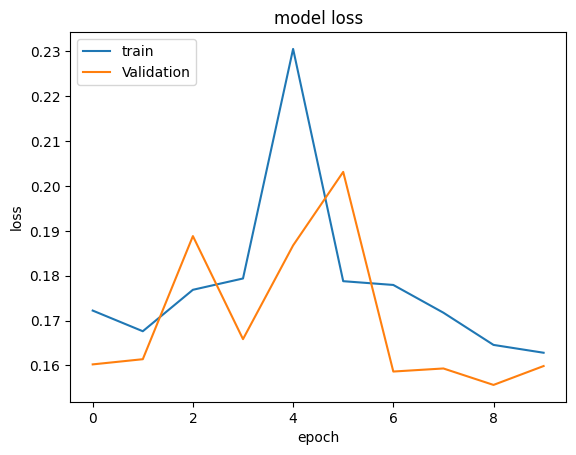

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

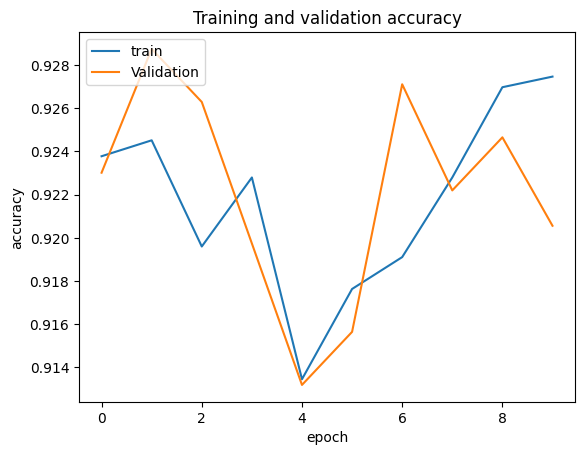

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

49/49 [==============================] - 0s 8ms/step
[[431  60   0]
 [116 416   0]
 [  0   0 537]]
0.8871794871794871
0.8870889119444031
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       491
           1       0.87      0.78      0.83       532
           2       1.00      1.00      1.00       537

    accuracy                           0.89      1560
   macro avg       0.89      0.89      0.89      1560
weighted avg       0.89      0.89      0.89      1560



<Axes: >

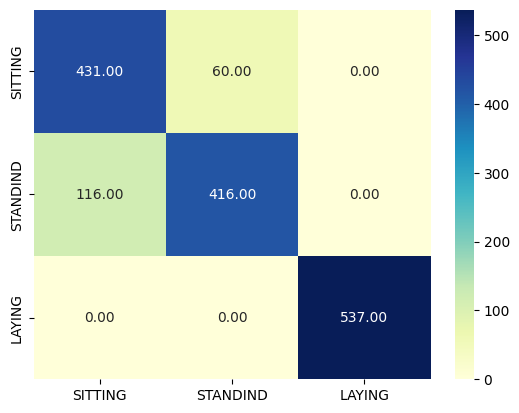

In [31]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')